In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

Reading Data and creating Features and Classification splits

In [3]:
# Read the data
df = pd.read_csv('data.csv', low_memory=False)

# Split into features and target
X = df.drop('cancer_type', axis=1)
X = X.drop('patient_id', axis=1)
y = df['cancer_type']

Converting Strings into one-hot encoded data

In [5]:
def encode_categorical_cols(cols, df=X):

    for col in cols:
        df[col] = df[col].fillna("missing") # Fills NA values with a string 

        df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=True) # Categorizes

        df[col] = df[col].cat.codes # Replaces strings with categories

    return df

nominal_cols =[]

# Automatically fill nominal_cols with columns containing strings that are not in ordinal_cols
for col in X.columns:
    if X[col].dtype == 'object':
        nominal_cols.append(col)

# Encode categorical columns
X = encode_categorical_cols(nominal_cols)
X = X.fillna(0)

label_encoder = LabelEncoder()

# Convert string labels to integer labels
y = label_encoder.fit_transform(y)

Splitting the features into train, validation, and test datasets. Then oversampling minority classes and normalizing data.

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
) # Splits data into 80% training and 20% testing
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True
) # Splits the 80% training into 60% training and 20% validation
print('Distribution in y_train:', np.bincount(y_train))
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train) # Oversamples minority classes

print('Distribution in y_train:', np.bincount(y_train))
print('Distribution in y_val:', np.bincount(y_val))
print('Distribution in y_test:', np.bincount(y_test))

# Normalizing numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

Distribution in y_train: [719  68  11  99]
Distribution in y_train: [719 719 719 719]
Distribution in y_val: [240  23   3  33]
Distribution in y_test: [240  23   4  33]


Building the Model

In [10]:
def build_model(input_shape, num_classes):
    model = Sequential([
        # Input layer
        Input(shape=input_shape), 
        # Dense Layers
        Dense(360, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.7),
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = X_train.shape[1:] # Input shape is number of features
num_classes = len(np.unique(y)) # Number of classes is the number of unique instances of y

model = build_model(input_shape, num_classes) # Builds model
# Implementing Early Stopping to avoid overfitting 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary() # Prints out model summary

# Fitting the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:f}%")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 360)            │       247,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 360)            │         1,440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        92,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,124 (1.43 MB)

 Trainable params: 374,636 (1.43 MB)

 Non-trainable params: 1,488 (5.81 KB)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3493 - loss: 5.9660 - val_accuracy: 0.4916 - val_loss: 4.6533
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5262 - loss: 4.7430 - val_accuracy: 0.4047 - val_loss: 4.4612
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6317 - loss: 4.0709 - val_accuracy: 0.4615 - val_loss: 4.0328
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7104 - loss: 3.5450 - val_accuracy: 0.5251 - val_loss: 3.7078
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7541 - loss: 3.1441 - val_accuracy: 0.5217 - val_loss: 3.3814
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8006 - loss: 2.7488 - val_accuracy: 0.6187 - val_loss: 3.0296
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8509 - loss: 2.3955 - val_accuracy: 0.6756 - val_loss: 2.7605
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8941 - loss: 2.0900 - val_accuracy: 0.6890 -

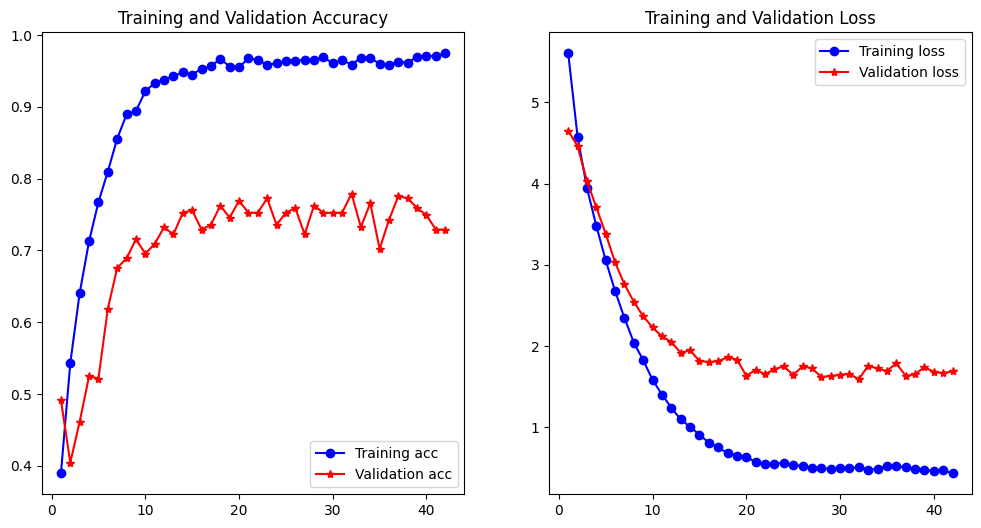

In [12]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [ ]:
model.save('Breast_Cancer_Classification_Model.keras') # To save the model

In [ ]:
model = load_model('Breast_Cancer_Classification_Model.keras') # To load the model